# Analysis Project: Post Patch vs Cell Depth

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline

In [2]:
ps = pd.read_csv("patch_seq_log_mouse.csv")

In [3]:
select = ["Date", "Depth (um)", "Post patch?", "Nucleus sucked in?", "Post patch pipette R", "PCR cycles", "SM_QC_PF", "Bad dates"]
ps = ps[select]

#Changing Date Format
ps["Date"] = pd.to_datetime(ps["Date"], format = "%y%m%d")

#Categories
ps["Post patch?"] = ps["Post patch?"].astype("category")
ps["Nucleus sucked in?"] = ps["Nucleus sucked in?"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")

#Filtering Columns
ps = ps[ps["PCR cycles"] == 21]      #shows 21 pcr cycles
ps = ps[ps["SM_QC_PF"] != "cnt"]     #shows everything except cnt
ps = ps[ps["Bad dates"] != "x"]      #shows everthing except x

#ps.dropna(subset = ["Post patch?", "Nucleus sucked in?"], returns start date 10/02/17 and data after that date
ps.dropna(subset = ["Post patch?", "SM_QC_PF"], inplace = True)
ps.head()

,Date,Depth (um),Post patch?,Nucleus sucked in?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates
4968,2017-04-19,56.3,Outside-Out,NaN,NaN,21.0,fail,NaN
4969,2017-04-19,28.5,Outside-Out,NaN,NaN,21.0,pass,NaN
4970,2017-04-19,53.8,No-Seal,NaN,NaN,21.0,fail,NaN
4971,2017-04-19,24.5,Nucleated,NaN,NaN,21.0,pass,NaN
4972,2017-04-19,40.7,Outside-Out,NaN,NaN,21.0,pass,NaN


In [4]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861 entries, 4968 to 7596
Data columns (total 8 columns):
Date                    1861 non-null datetime64[ns]
Depth (um)              1589 non-null object
Post patch?             1861 non-null category
Nucleus sucked in?      240 non-null category
Post patch pipette R    240 non-null float64
PCR cycles              1861 non-null float64
SM_QC_PF                1861 non-null category
Bad dates               0 non-null object
dtypes: category(3), datetime64[ns](1), float64(2), object(2)
memory usage: 93.8+ KB


## Definitions

In [5]:
#Clarify if cutoff should be 500 and 501 or 500 and 499
#Defines each post patch category 

def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 501))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 500))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 501))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 500))]
    return no
    
def entire_cell(v):
    entire = v[(v["Post patch?"] == 'Entire-Cell') | (v['Post patch?'] == 'entire_cell')]
    return entire

## Creating a Dataframe by Post Patch Class

In [6]:
#Labelling each post patch category
#This creates a column returning the "___" for the defined categories above

nuc = nucleated(ps)
nuc["post patch class"] = "Nucleated"

part_nuc = partial_nucleated(ps)
part_nuc["post patch class"] = "Partial nucleated"

out_out = outside_out(ps)
out_out["post patch class"] = "Outside out"

noSeal = no_seal(ps)
noSeal["post patch class"] = "No seal"

entirecell = entire_cell(ps)
entirecell["post patch class"] = "Entire Cell"

ps.head()

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

,Date,Depth (um),Post patch?,Nucleus sucked in?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates
4968,2017-04-19,56.3,Outside-Out,NaN,NaN,21.0,fail,NaN
4969,2017-04-19,28.5,Outside-Out,NaN,NaN,21.0,pass,NaN
4970,2017-04-19,53.8,No-Seal,NaN,NaN,21.0,fail,NaN
4971,2017-04-19,24.5,Nucleated,NaN,NaN,21.0,pass,NaN
4972,2017-04-19,40.7,Outside-Out,NaN,NaN,21.0,pass,NaN


In [7]:
#This puts data in order the frames list 
#All nucleated data is shown then partial nuc then outside-out...as continues inside brackets

frames = [nuc, part_nuc, out_out, noSeal, entirecell]
ps = pd.concat(frames)
ps.head(10)

,Date,Depth (um),Post patch?,Nucleus sucked in?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates,post patch class
4971,2017-04-19,24.5,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
4973,2017-04-19,17.6,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
4975,2017-04-19,40.2,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
4988,2017-04-20,56.2,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
4997,2017-04-20,55.4,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
5009,2017-04-20,33.8,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
5022,2017-04-21,NaN,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
5026,2017-04-21,44.9,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
5027,2017-04-21,24.2,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
5035,2017-04-21,31.2,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated


## Trial & Error Section

In [8]:
ps["post patch class"].value_counts()

Nucleated            851
No seal              641
Partial nucleated    235
Outside out          110
Entire Cell           22
Name: post patch class, dtype: int64

In [9]:
#Not sure about this just experimenting, refer to Rusty's example of Post patch by cre-line
#Dropping specific columns that are labeled within the brackets
#You don't need to add labels or axis, that is how the method is labeled, press shift+tab to check

ps0 = ps.drop(labels = ["Post patch?", "PCR cycles", "SM_QC_PF", "Bad dates"], axis = 1)
ps0.head()

,Date,Depth (um),Nucleus sucked in?,Post patch pipette R,post patch class
4971,2017-04-19,24.5,NaN,NaN,Nucleated
4973,2017-04-19,17.6,NaN,NaN,Nucleated
4975,2017-04-19,40.2,NaN,NaN,Nucleated
4988,2017-04-20,56.2,NaN,NaN,Nucleated
4997,2017-04-20,55.4,NaN,NaN,Nucleated


In [10]:
#Created a new csv with the updated ps0 
ps0.to_csv("depth_post")

In [11]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859 entries, 4971 to 7588
Data columns (total 9 columns):
Date                    1859 non-null datetime64[ns]
Depth (um)              1588 non-null object
Post patch?             1859 non-null category
Nucleus sucked in?      239 non-null category
Post patch pipette R    239 non-null float64
PCR cycles              1859 non-null float64
SM_QC_PF                1859 non-null category
Bad dates               0 non-null object
post patch class        1859 non-null object
dtypes: category(3), datetime64[ns](1), float64(2), object(3)
memory usage: 108.2+ KB


In [12]:
#6875 Outlier, Depth = 675
ps.sort_index().tail(600)

,Date,Depth (um),Post patch?,Nucleus sucked in?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates,post patch class
6875,2017-08-07,675,No-Seal,NaN,NaN,21.0,pass,NaN,No seal
6876,2017-08-07,33.8,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
6877,2017-08-07,39.9,No-Seal,NaN,NaN,21.0,pass,NaN,No seal
6878,2017-08-07,59.8,No-Seal,NaN,NaN,21.0,pass,NaN,No seal
6881,2017-08-07,NaN,No-Seal,NaN,NaN,21.0,fail,NaN,No seal
6882,2017-08-07,NaN,Nucleated,NaN,NaN,21.0,fail,NaN,Nucleated
6883,2017-08-07,NaN,No-Seal,NaN,NaN,21.0,pass,NaN,No seal
6884,2017-08-07,33,Partial-Nucleus,NaN,NaN,21.0,pass,NaN,Partial nucleated
6885,2017-08-07,54,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
6886,2017-08-07,71,Partial-Nucleus,NaN,NaN,21.0,pass,NaN,Partial nucleated


## Misc

ps["Post patch?"].value_counts()
ps["Nucleus sucked in?"].value_counts()
ps.dtypes
ps.info()

All categories for post patch...up till 10/02/2017 
All categories for nucleus sucked in?... starts at 10/02/2017
For post patch pipette R and nucleus sucked in?... starts at 10/02/2017

depth = numerical 
post patch? = categorical 
post patch pipette R = numerical 
nucleus sucked in? = categorical

## Graphing

In [13]:
#Either use Box & Whisker Plot OR Histogram. 
#But Whisker Plot would be easier and cleaner to display 5 categories.
#You need to display 5 categories of patching and the range of the depth values. 

#Displayed data
#Title = Post Patch vs Cell Depth
#x-axis = Post Patch
#y-axis = Cell Depth

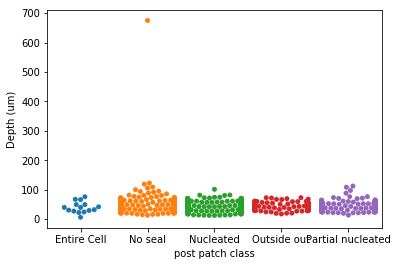

In [14]:
#This is not the right plot but using for trial and error

ps["Depth (um)"] = pd.to_numeric(ps["Depth (um)"].str.replace(' ',''), errors ='force')
ps["post patch class"] = ps["post patch class"].astype("category")
sns.swarmplot(x='post patch class', y='Depth (um)', size = 5, data=ps)

Text(0.5,1,'Post patch vs Cell Depth (um)')

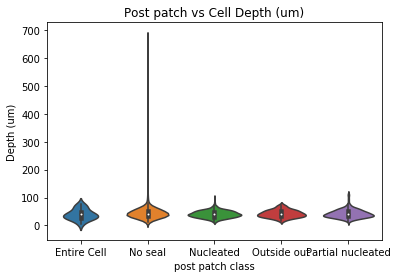

In [15]:
#This is not the right plot but using for trial and error

sns.violinplot(x='post patch class', y='Depth (um)', data = ps)
plt.title("Post patch vs Cell Depth (um)")

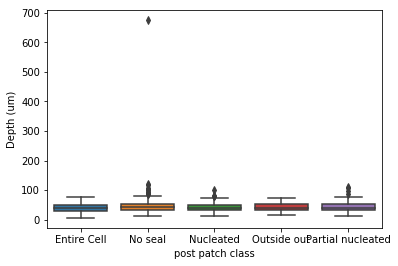

In [16]:
#Boxplot trial and error
#Boxplot is squished because of the outlier
sns.boxplot(x='post patch class', y='Depth (um)', data = ps)

In [17]:
#6875, No seal, Depth = 675, outlier (Dropped this outlier)
ps.drop(labels = 6875, inplace = True)
ps.sort_index().tail(600)

,Date,Depth (um),Post patch?,Nucleus sucked in?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates,post patch class
6874,2017-08-07,43.5,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
6876,2017-08-07,33.8,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
6877,2017-08-07,39.9,No-Seal,NaN,NaN,21.0,pass,NaN,No seal
6878,2017-08-07,59.8,No-Seal,NaN,NaN,21.0,pass,NaN,No seal
6881,2017-08-07,NaN,No-Seal,NaN,NaN,21.0,fail,NaN,No seal
6882,2017-08-07,NaN,Nucleated,NaN,NaN,21.0,fail,NaN,Nucleated
6883,2017-08-07,NaN,No-Seal,NaN,NaN,21.0,pass,NaN,No seal
6884,2017-08-07,33.0,Partial-Nucleus,NaN,NaN,21.0,pass,NaN,Partial nucleated
6885,2017-08-07,54.0,Nucleated,NaN,NaN,21.0,pass,NaN,Nucleated
6886,2017-08-07,71.0,Partial-Nucleus,NaN,NaN,21.0,pass,NaN,Partial nucleated


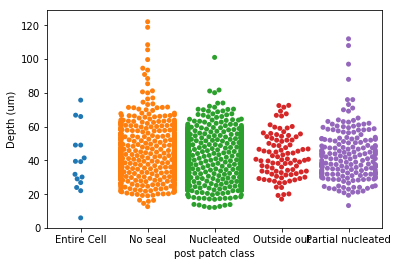

In [18]:
#This is not the right plot but using for trial and error

sns.swarmplot(x='post patch class', y='Depth (um)', size = 5, data=ps)

Text(0.5,1,'Post patch vs Cell Depth (um)')

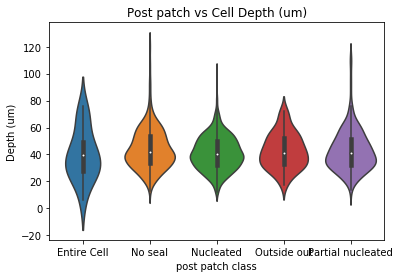

In [19]:
#This is not the right plot but using for trial and error

sns.violinplot(x='post patch class', y='Depth (um)', data = ps)
plt.title("Post patch vs Cell Depth (um)")

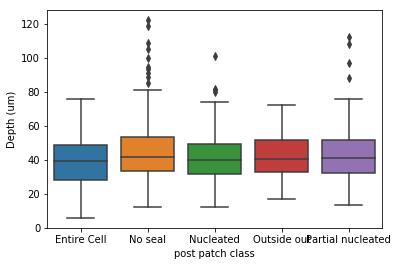

In [20]:
#Boxplot trial and error
sns.boxplot(x='post patch class', y='Depth (um)', data = ps)